Transform data into dataframe to be investigated   

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sell_in = pd.read_csv('../data/sell-in.txt', sep='\t')
stocks = pd.read_csv('../data/tb_stocks.txt', sep='\t')
productos = pd.read_csv('../data/tb_productos.txt', sep='\t')

sell_in['periodo'] = pd.to_datetime(sell_in['periodo'].astype(str) + '01', format='%Y%m%d')
stocks['periodo'] = pd.to_datetime(stocks['periodo'].astype(str) + '01', format='%Y%m%d')

In [2]:
print("\nSell-in info:\n", sell_in.info())
print(sell_in.head())
print("\nStocks info:\n", stocks.info())
print(stocks.head())
print("\nProductos info:\n", productos.info())
print(productos.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945818 entries, 0 to 2945817
Data columns (total 7 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   periodo                datetime64[ns]
 1   customer_id            int64         
 2   product_id             int64         
 3   plan_precios_cuidados  int64         
 4   cust_request_qty       int64         
 5   cust_request_tn        float64       
 6   tn                     float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 157.3 MB

Sell-in info:
 None
     periodo  customer_id  product_id  plan_precios_cuidados  \
0 2017-01-01        10234       20524                      0   
1 2017-01-01        10032       20524                      0   
2 2017-01-01        10217       20524                      0   
3 2017-01-01        10125       20524                      0   
4 2017-01-01        10012       20524                      0   

   cust_request_qty  cus

In [3]:
print("\nSell-in period range:", sell_in['periodo'].min(), sell_in['periodo'].max())
print("Stocks period range:", stocks['periodo'].min(), stocks['periodo'].max())
print("Sell-in products:", sell_in['product_id'].nunique())
print("Stock products:", stocks['product_id'].nunique())
print("Productos products:", productos['product_id'].nunique())


Sell-in period range: 2017-01-01 00:00:00 2019-12-01 00:00:00
Stocks period range: 2018-10-01 00:00:00 2019-12-01 00:00:00
Sell-in products: 1233
Stock products: 1095
Productos products: 1251


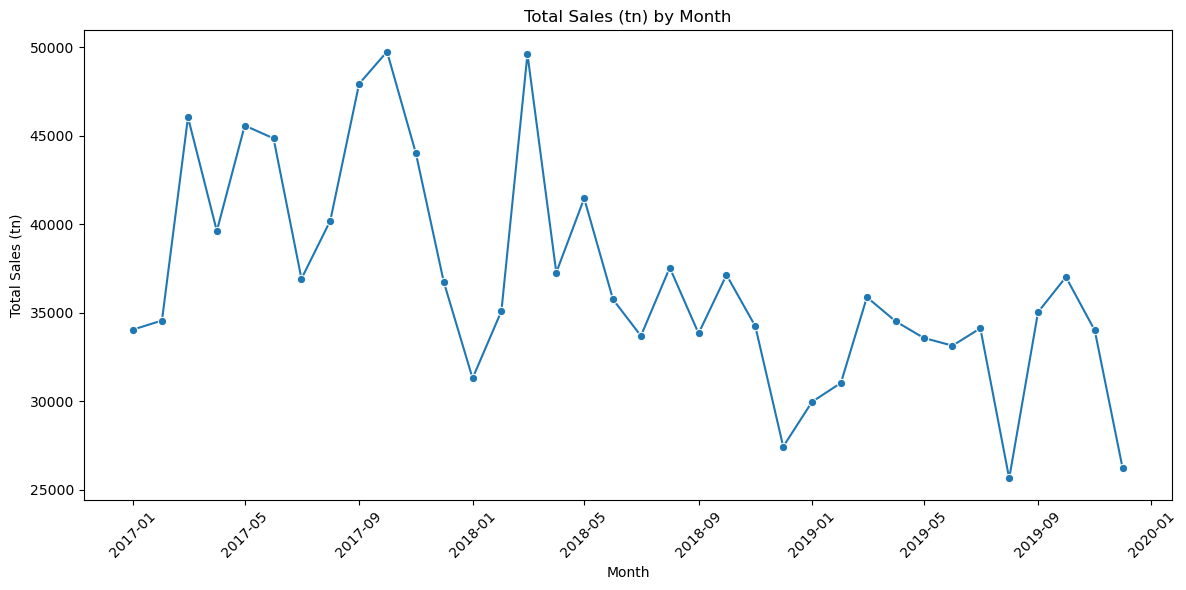

In [4]:
sales_by_month = sell_in.groupby('periodo')['tn'].sum().reset_index()
#sales_by_month['periodo'] = pd.to_datetime(sales_by_month['periodo'].astype(str) + '01', format='%Y%m%d')

plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_by_month, x='periodo', y='tn', marker='o')
plt.title('Total Sales (tn) by Month')
plt.ylabel('Total Sales (tn)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

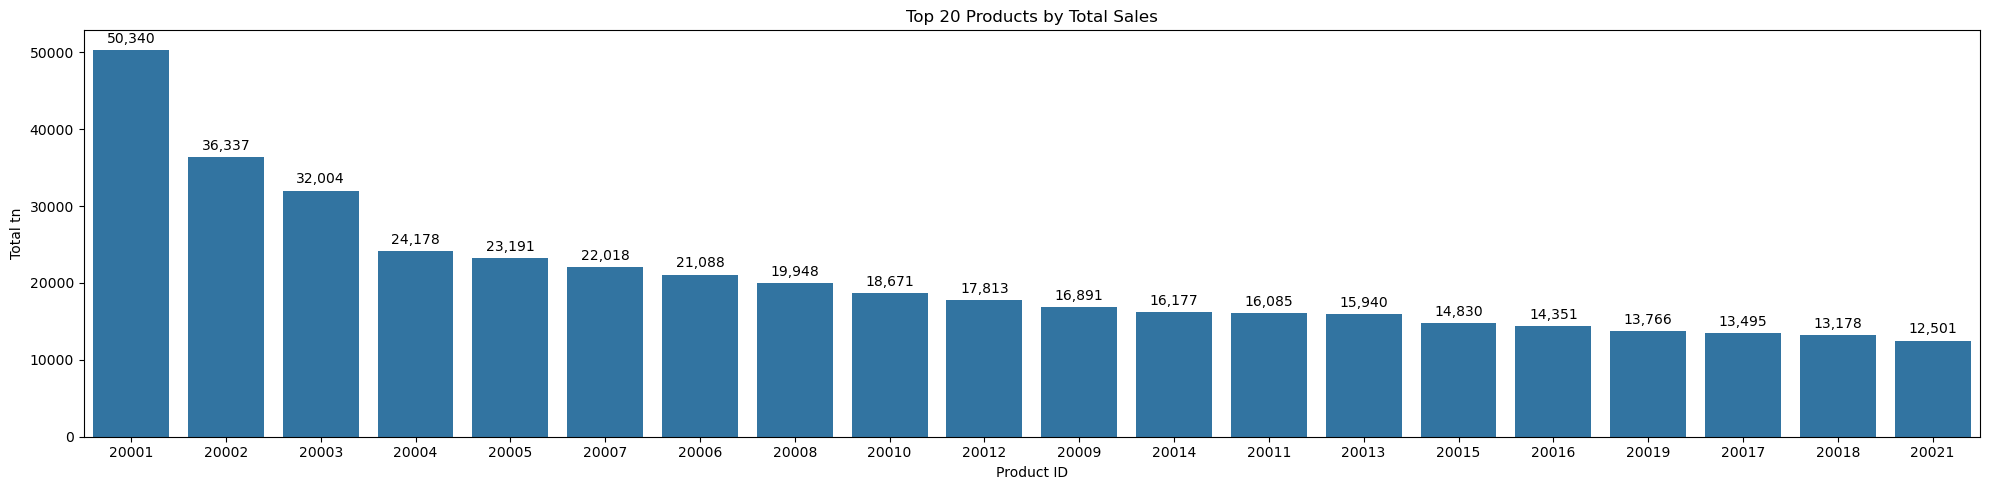

In [5]:
top_products = sell_in.groupby('product_id')['tn'].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(20, 5))
ax = sns.barplot(x=top_products.index.astype(str), y=top_products.values)

plt.title('Top 20 Products by Total Sales')
plt.ylabel('Total tn')
plt.xlabel('Product ID')

# Add value labels to bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',  # formatted with thousands separator
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

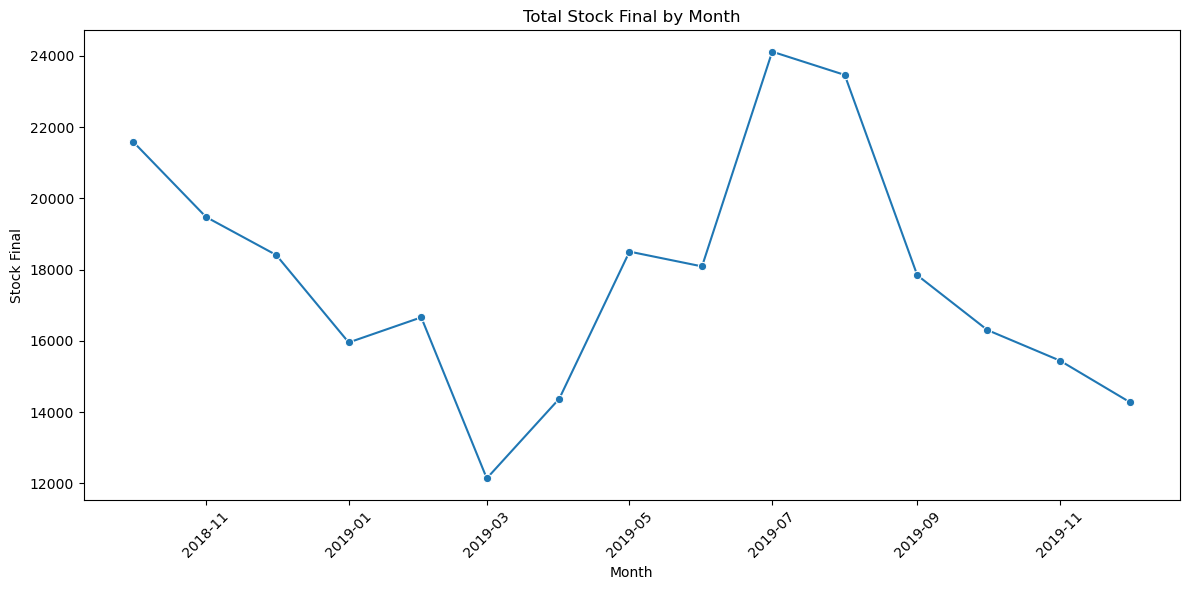

In [6]:
stock_by_month = stocks.groupby('periodo')['stock_final'].sum().reset_index()
#stock_by_month['periodo'] = pd.to_datetime(stock_by_month['periodo'].astype(str) + '01', format='%Y%m%d')

plt.figure(figsize=(12, 6))
sns.lineplot(data=stock_by_month, x='periodo', y='stock_final', marker='o')
plt.title('Total Stock Final by Month')
plt.ylabel('Stock Final')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

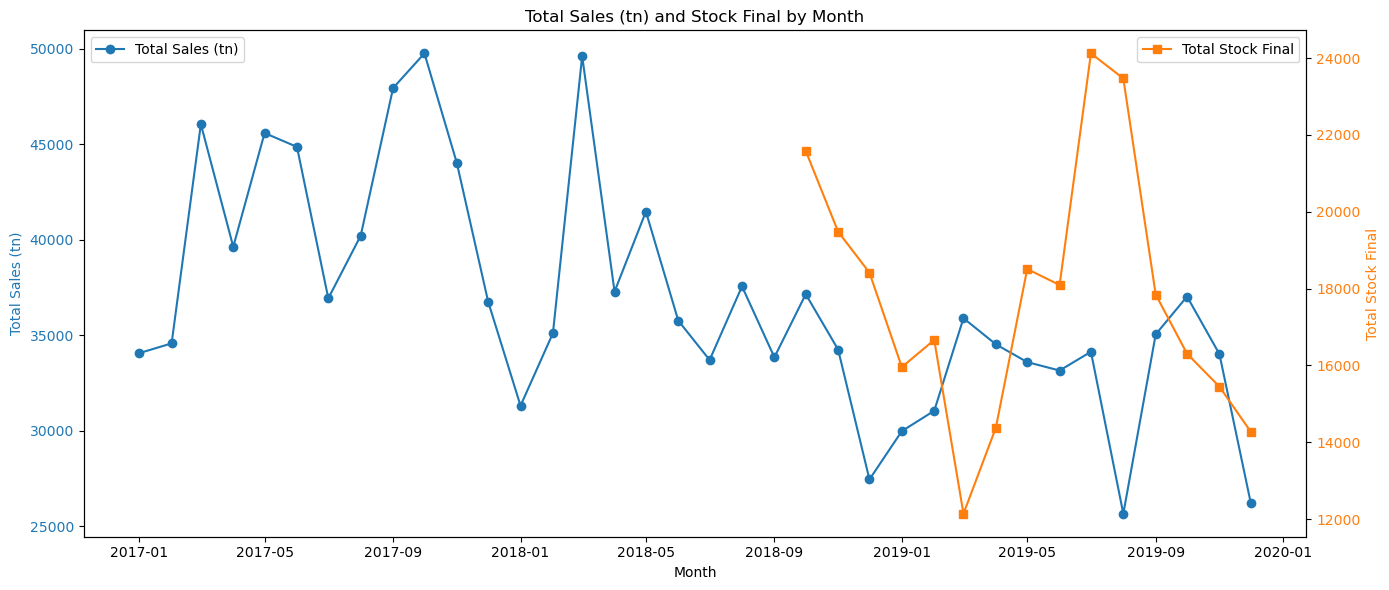

In [7]:
merged = pd.merge(sales_by_month, stock_by_month, on='periodo', how='outer', suffixes=('_sales', '_stock'))
merged = merged.sort_values('periodo')
fig, ax1 = plt.subplots(figsize=(14,6))

color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Sales (tn)', color=color)
ax1.plot(merged['periodo'], merged['tn'], marker='o', color=color, label='Total Sales (tn)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # segundo eje y
color = 'tab:orange'
ax2.set_ylabel('Total Stock Final', color=color)
ax2.plot(merged['periodo'], merged['stock_final'], marker='s', color=color, label='Total Stock Final')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Total Sales (tn) and Stock Final by Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


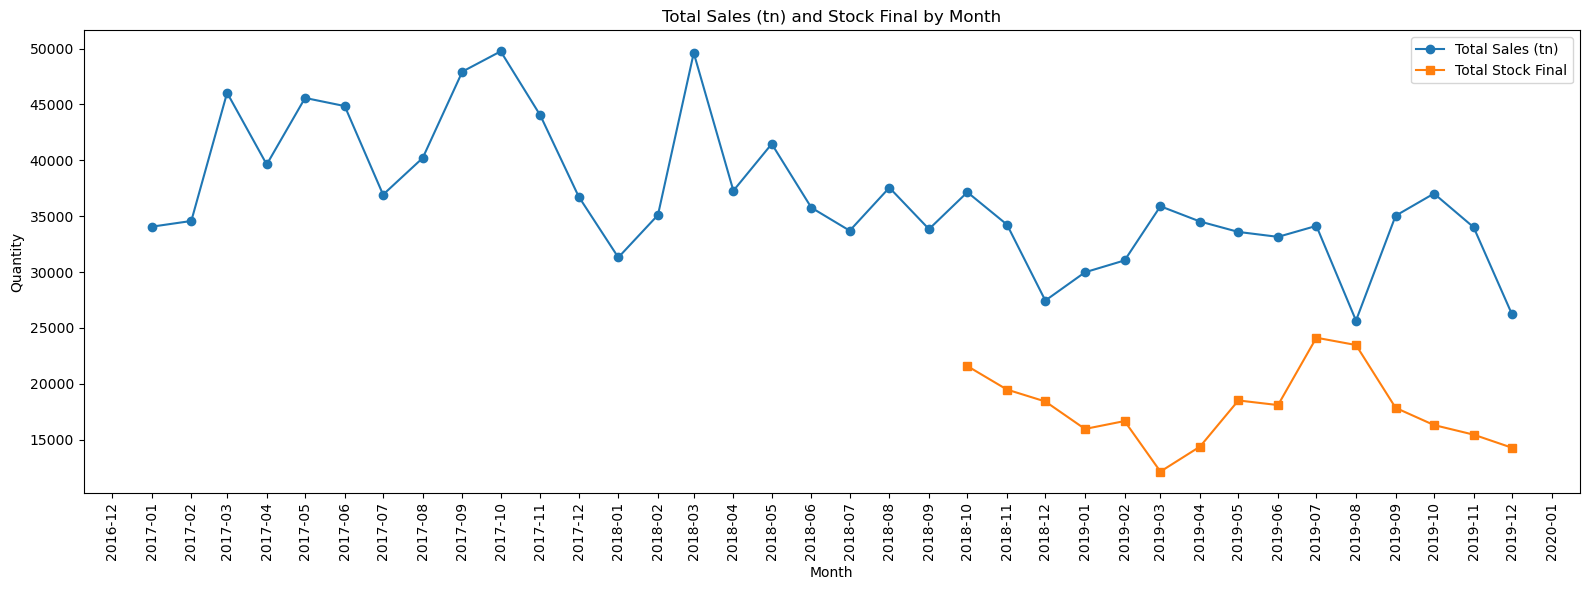

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(16, 6))

# Graficar ambas series
ax.plot(merged['periodo'], merged['tn'], marker='o', label='Total Sales (tn)')
ax.plot(merged['periodo'], merged['stock_final'], marker='s', label='Total Stock Final')

# -- GRANULARIDAD POR MES --
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Tick cada mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Etiqueta 'YYYY-MM'

plt.title('Total Sales (tn) and Stock Final by Month')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.xticks(rotation=90, ha='center')  # Etiquetas verticales para mejor lectura
plt.legend()
plt.tight_layout()
plt.show()

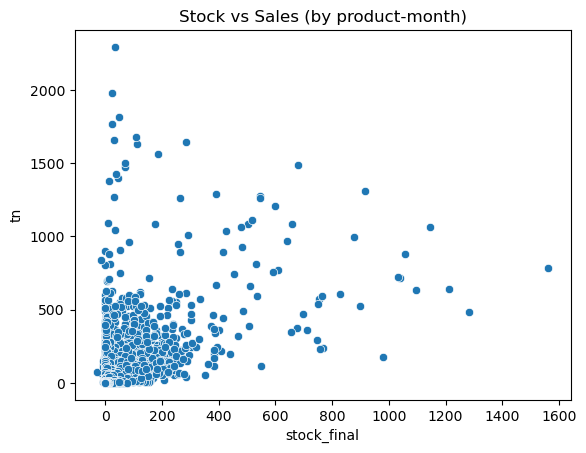

Correlation between stock and sales:
              stock_final        tn
stock_final     1.000000  0.523632
tn              0.523632  1.000000


In [9]:
sales_agg = sell_in.groupby(['periodo', 'product_id'])['tn'].sum().reset_index()
stocks_agg = stocks.groupby(['periodo', 'product_id'])['stock_final'].sum().reset_index()
df_merged = pd.merge(sales_agg, stocks_agg, on=['periodo', 'product_id'], how='inner')

sns.scatterplot(data=df_merged, x='stock_final', y='tn')
plt.title('Stock vs Sales (by product-month)')
plt.show()

corr = df_merged[['stock_final', 'tn']].corr()
print("Correlation between stock and sales:\n", corr)

In [10]:
from ydata_profiling import ProfileReport

c:\Users\leona\anaconda3\envs\py310lab3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Generate the report
profile = ProfileReport(sell_in, title='Sell-in EDA Report', explorative=True)

# Save the report as HTML
profile.to_file('../reports/sellin_profiling_report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 166.55it/s]


In [12]:
profile_stocks = ProfileReport(stocks, title='Stocks EDA Report', explorative=True)
profile_stocks.to_file('../reports/stocks_profiling_report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 250.17it/s]


In [13]:

profile_prod = ProfileReport(productos, title='Productos EDA Report', explorative=True)
profile_prod.to_file('../reports/productos_profiling_report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 250.27it/s]


In [14]:
cant_duplicados = productos.duplicated(subset=['product_id']).sum()
print(f'Hay {cant_duplicados} product_id duplicados')

Hay 11 product_id duplicados


In [15]:
productos.drop_duplicates(subset=['product_id'], inplace=True)

In [16]:
# Supongamos que tu DataFrame de productos se llama 'productos'
nivea_prods = productos[productos['brand'].str.upper() == 'NIVEA']

# Lista de product_id NIVEA
nivea_ids = nivea_prods['product_id'].unique()
print(nivea_ids)

[20876 20703 20738 20434 20290 20571 20368 20401 20256 20748 20469 20909
 20955 20869 20727 20879 20833 20330 20212 20335 21175 20534 20444 20766
 20867 20734 20934 20662 20417 20631 20815 20343 20915 20673 20946 20535
 20901 20768 20856 20783 20793 20831 20853 21026 20981 21054 20658 20622
 20642 20651 21087 21126 20769 20943 20340 20598 20610 20971 21276 21069
 20809 21039 20933 20830 20696 20963 20959 20826 20680 20952 20977 20969
 21294 21094 20755 20718 21260 20776 20410 21115 21082 20569 20679 20315
 20720 20122 20359 20453 20349 20924 20967 21035 21214 20887 20777 20697
 20839 20807 20973 20908 20913 20326 20954 21084 21109 21171 21008 20637
 21153 21168 21159 20864 20419 20058 20619 20283 20486 20892 21013 20874
 20788 21107 21004 21021 21006 20896 20488 20711 21267 21252 21269 20605
 20942 20899 21060 20500 20775 21243 20744 20639 20932 20782 21130 20628
 20784 20914 20857 20789 20819 20690 20686 20704 20400 20275 20837 20710
 20541 20351 20365 20244 20791 20406 20938 20861 20

In [17]:
nivea_ventas = sell_in[sell_in['product_id'].isin(nivea_ids)]

In [18]:
print(nivea_ventas['tn'].sum())

39432.698849999986


In [19]:
ventas_x_prod = nivea_ventas.groupby('product_id')['tn'].sum().sort_values(ascending=False)
print(ventas_x_prod)

product_id
20058    5164.65993
20122    2598.75056
20189    1236.86935
20212    1037.30178
20244     812.42338
            ...    
21260       1.62513
21267       0.92835
21269       0.87024
21276       0.45447
21294       0.00764
Name: tn, Length: 179, dtype: float64


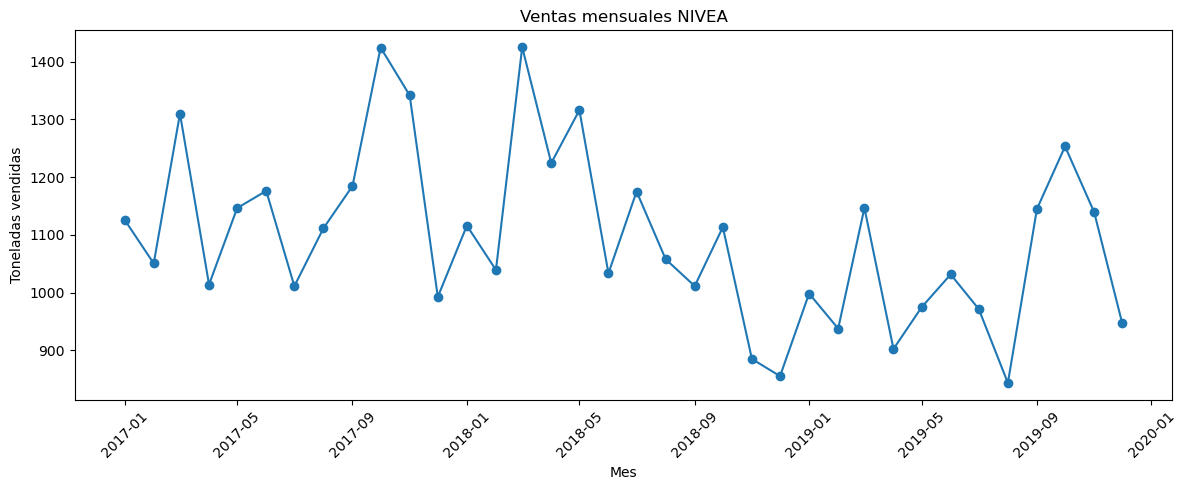

In [20]:
ventas_mes = nivea_ventas.groupby('periodo')['tn'].sum().reset_index()
import matplotlib.pyplot as plt
import pandas as pd
#ventas_mes['periodo'] = pd.to_datetime(ventas_mes['periodo'].astype(str) + '01', format='%Y%m%d')
plt.figure(figsize=(12,5))
plt.plot(ventas_mes['periodo'], ventas_mes['tn'], marker='o')
plt.title('Ventas mensuales NIVEA')
plt.xlabel('Mes')
plt.ylabel('Toneladas vendidas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
sell_in_mas_info = sell_in.merge(productos[['product_id', 'brand']], on='product_id', how='left')
ventas_x_marca = sell_in_mas_info.groupby('brand')['tn'].sum().sort_values(ascending=False)
print(ventas_x_marca.head(10))

brand
LIMPIEX     331872.06249
NATURA      134827.75922
MUSCULO     122386.51699
ARIEL       105470.46206
ROPEX1      105330.05370
DOWNY        85823.02822
MAGGI        67055.13173
SHAMPOO2     65273.06362
SHAMPOO3     64895.63962
DEOS1        49637.79340
Name: tn, dtype: float64


In [22]:
# Supongamos que tu DataFrame de ventas se llama 'sell_in'
mas_vendido = sell_in.groupby('product_id')['tn'].sum().sort_values(ascending=False)
print("Ranking de productos más vendidos (tn):")
print(mas_vendido.head(10))  # Los 10 más vendidos

# El id del producto más vendido:
id_mas_vendido = mas_vendido.idxmax()
print(f"\nEl product_id más vendido es: {id_mas_vendido} con un total de {mas_vendido.max():.2f} tn")


Ranking de productos más vendidos (tn):
product_id
20001    50340.39558
20002    36337.25439
20003    32004.15274
20004    24178.15379
20005    23191.21852
20007    22018.45234
20006    21088.76007
20008    19948.29352
20010    18671.07918
20012    17813.59935
Name: tn, dtype: float64

El product_id más vendido es: 20001 con un total de 50340.40 tn


In [23]:
contados = sell_in['product_id'].value_counts()
print("Ranking por cantidad de ventas registradas:")
print(contados.head(10))

Ranking por cantidad de ventas registradas:
product_id
20111    7973
20122    7950
20120    7537
20326    7397
20132    7199
20004    7139
20276    7097
20058    7006
20013    6964
20027    6964
Name: count, dtype: int64


In [24]:
ventas_mes_prod = sell_in.groupby(['periodo', 'product_id'])['tn'].sum().reset_index()
mas_vendidos_x_mes = ventas_mes_prod.loc[ventas_mes_prod.groupby('periodo')['tn'].idxmax()]
print(mas_vendidos_x_mes)

         periodo  product_id          tn
2     2017-01-01       20003  1063.45835
785   2017-02-01       20001   798.01620
1566  2017-03-01       20001  1303.35771
2352  2017-04-01       20001  1069.96130
3136  2017-05-01       20001  1502.20132
3942  2017-06-01       20001  1520.06539
4765  2017-07-01       20001  1030.67391
5591  2017-08-01       20001  1267.39462
6440  2017-09-01       20003  1465.83347
7269  2017-10-01       20003  1958.59845
8116  2017-11-01       20001  1580.47401
8976  2017-12-01       20001  1049.38860
9832  2018-01-01       20001  1169.07532
10686 2018-02-01       20001  1043.76470
11534 2018-03-01       20001  1856.83534
12387 2018-04-01       20001  1251.28462
13241 2018-05-01       20001  1293.89788
14105 2018-06-01       20001  1150.79169
14956 2018-07-01       20001  1470.41009
15802 2018-08-01       20001  1800.96168
16650 2018-09-01       20001  1438.67455
17525 2018-10-01       20001  2295.19832
18422 2018-11-01       20001  1813.01511
19320 2018-12-01

In [25]:
mas_vendido_df = mas_vendido.reset_index().merge(productos, on='product_id', how='left')
print(mas_vendido_df.head(1))  # El más vendido y sus datos

   product_id           tn cat1         cat2     cat3  brand  sku_size
0       20001  50340.39558   HC  ROPA LAVADO  Liquido  ARIEL    3000.0


Checklist for Deep EDA

* Missing Values: Any NA? Are there products with sales but no stock, or vice versa?
* Granularity: Is every (month, product, customer) present? Any gaps?
* Target Analysis: Plot histogram of sales per product, per month—are most values low/zero or is there a long tail?
* Seasonality: Is there a monthly/quarterly trend?
* Product Features: Are certain brands/categories overrepresented?
* Potential Features: Lagged sales, lagged stock, product static features (brand, size, etc.).

### Seasonality

In [26]:
sell_in['año'] = sell_in['periodo'].dt.year
sell_in['mes'] = sell_in['periodo'].dt.month
sell_in['trimestre'] = sell_in['periodo'].dt.quarter

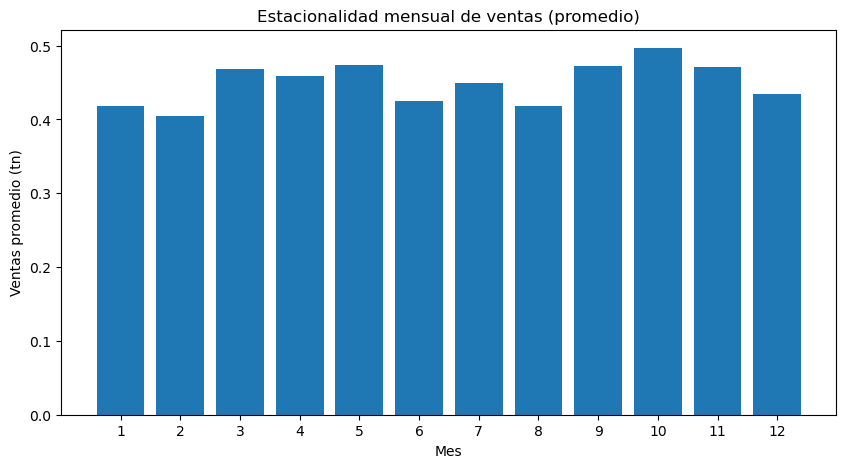

In [27]:
ventas_por_mes = sell_in.groupby('mes')['tn'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.bar(ventas_por_mes['mes'], ventas_por_mes['tn'])
plt.xlabel('Mes')
plt.ylabel('Ventas promedio (tn)')
plt.title('Estacionalidad mensual de ventas (promedio)')
plt.xticks(range(1,13))
plt.show()

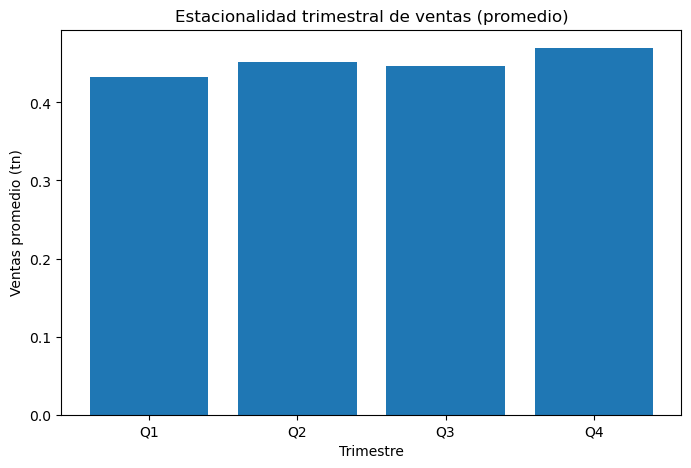

In [28]:
ventas_por_trim = sell_in.groupby('trimestre')['tn'].mean().reset_index()

plt.figure(figsize=(8,5))
plt.bar(ventas_por_trim['trimestre'], ventas_por_trim['tn'])
plt.xlabel('Trimestre')
plt.ylabel('Ventas promedio (tn)')
plt.title('Estacionalidad trimestral de ventas (promedio)')
plt.xticks([1,2,3,4], ['Q1','Q2','Q3','Q4'])
plt.show()

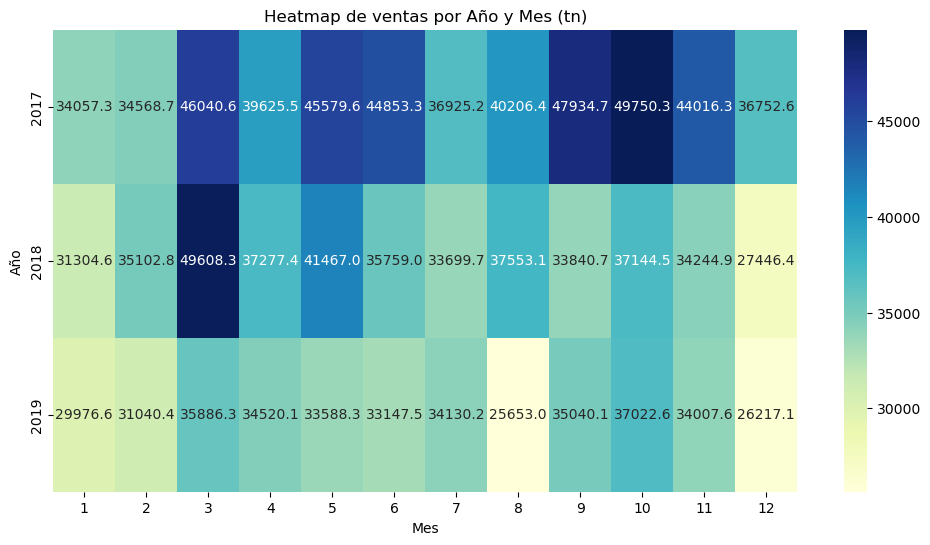

In [29]:
pivot = sell_in.groupby(['año','mes'])['tn'].sum().reset_index()
pivot_table = pivot.pivot(index='año', columns='mes', values='tn')
plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Heatmap de ventas por Año y Mes (tn)")
plt.xlabel("Mes")
plt.ylabel("Año")
plt.show()

In [30]:
sell_in_cat = sell_in.merge(productos[['product_id', 'cat1']], on='product_id', how='left')

In [31]:
sell_in_cat['año'] = sell_in_cat['periodo'].dt.year
sell_in_cat['mes'] = sell_in_cat['periodo'].dt.month

In [32]:
cat_principales = ['HC', 'PC', 'FOODS']
sell_in_cat = sell_in_cat[sell_in_cat['cat1'].isin(cat_principales)]

In [33]:
print(sell_in_cat[sell_in_cat['product_id'] == 20556][['product_id', 'cat1']].head(10))

       product_id   cat1
48686       20556  FOODS
48687       20556  FOODS
48688       20556  FOODS
48689       20556  FOODS
48690       20556  FOODS
48691       20556  FOODS
48692       20556  FOODS
48693       20556  FOODS
48694       20556  FOODS
48695       20556  FOODS


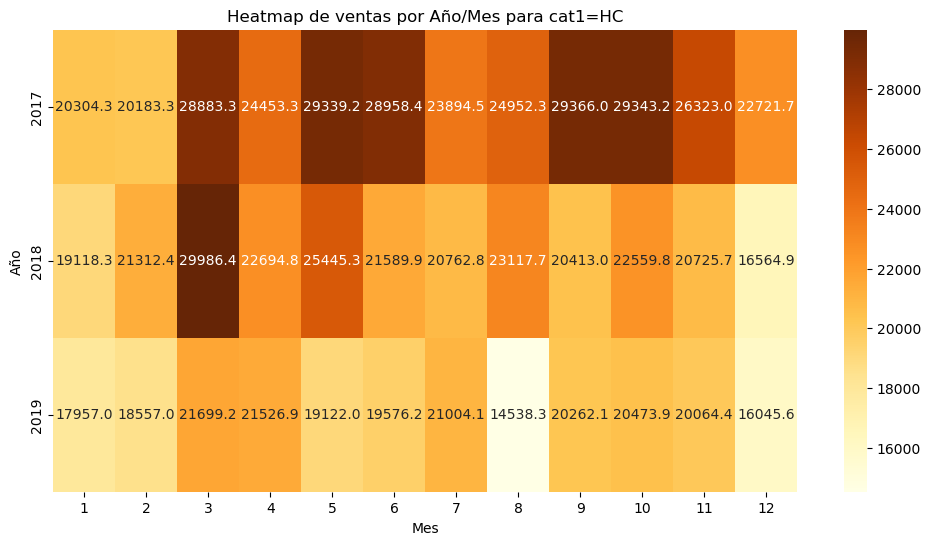

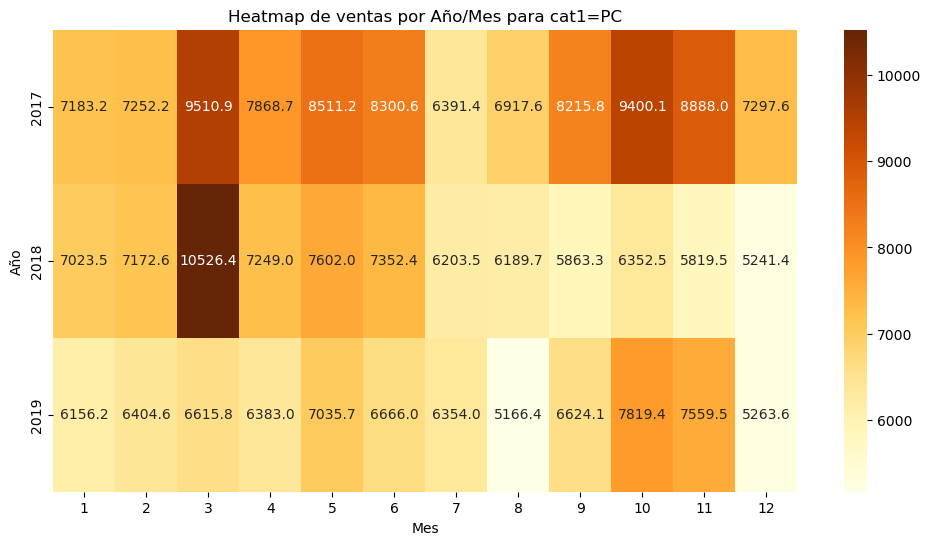

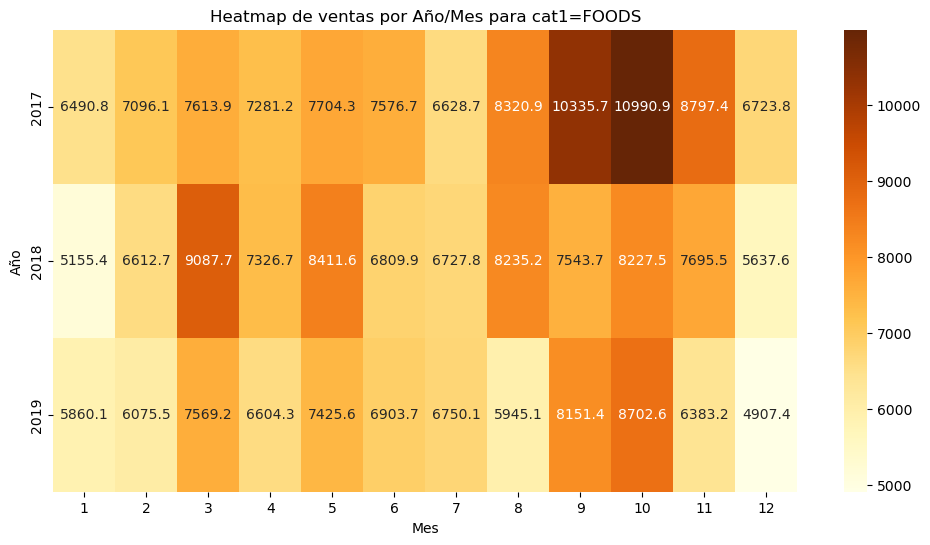

In [34]:
for cat in cat_principales:
    data = sell_in_cat[sell_in_cat['cat1'] == cat]
    tabla = data.groupby(['año', 'mes'])['tn'].sum().reset_index()
    if tabla.empty:
        print(f"Sin datos para cat1={cat}")
        continue
    pivot = tabla.pivot(index='año', columns='mes', values='tn')
    # chequeo si está vacío o solo tiene NaN
    if pivot.empty or pivot.isnull().all().all():
        print(f"Pivot vacío o solo NaN para cat1={cat}")
        continue
    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlOrBr")
    plt.title(f"Heatmap de ventas por Año/Mes para cat1={cat}")
    plt.xlabel("Mes")
    plt.ylabel("Año")
    plt.show()

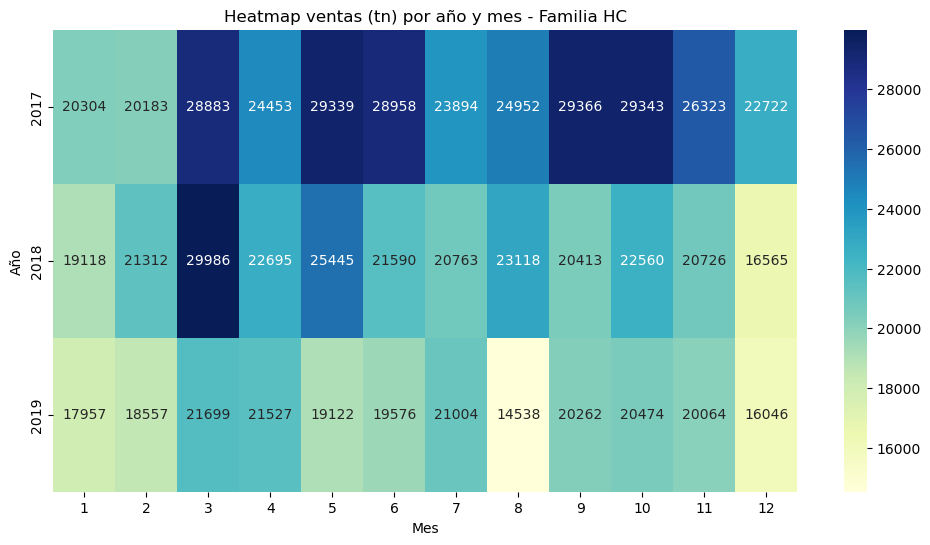

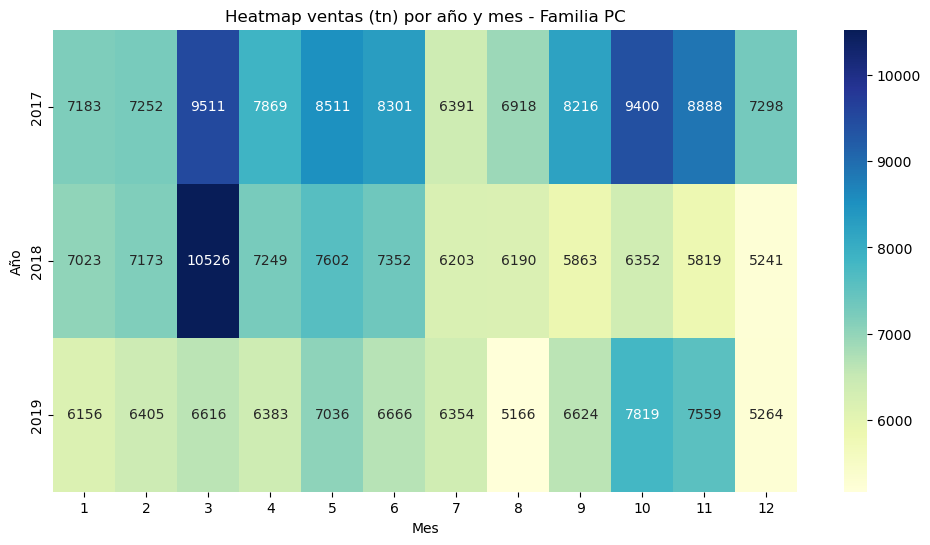

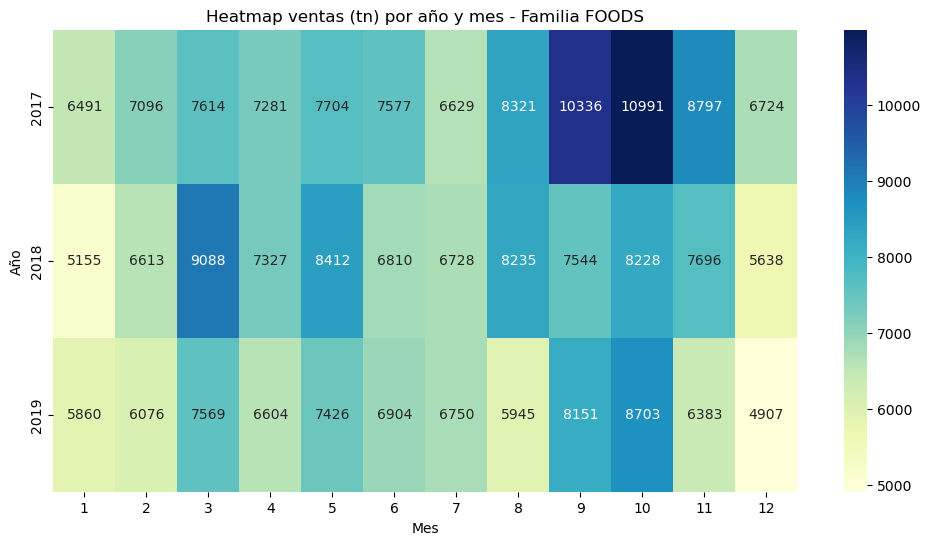

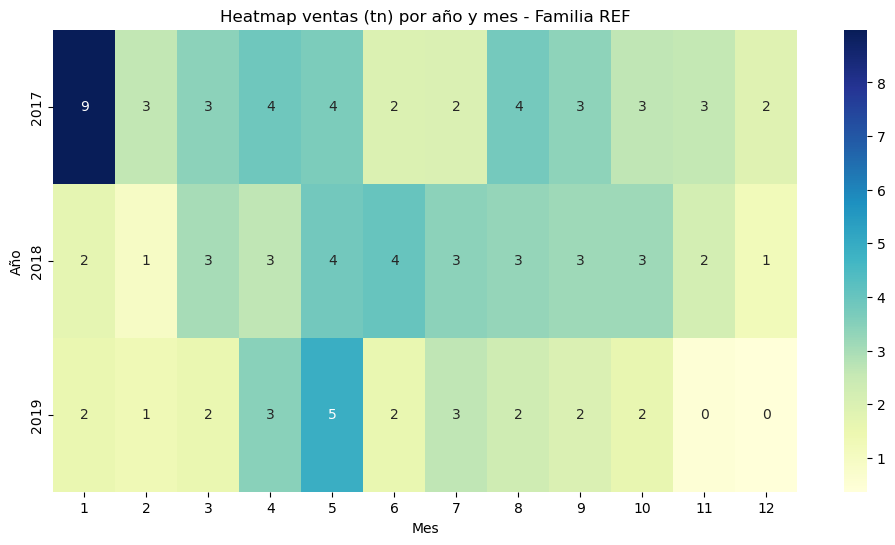

In [35]:
# Si no lo hiciste antes
ventas_familia = sell_in.merge(productos[['product_id', 'cat1']], on='product_id', how='left')

ventas_familia['año'] = ventas_familia['periodo'].dt.year
ventas_familia['mes'] = ventas_familia['periodo'].dt.month


familias = ventas_familia['cat1'].dropna().unique()  # Todas las familias
for fam in familias:
    data = ventas_familia[ventas_familia['cat1'] == fam]
    tabla = data.groupby(['año', 'mes'])['tn'].sum().reset_index()
    pivot = tabla.pivot(index='año', columns='mes', values='tn')
    if pivot.empty or pivot.isnull().all().all():
        print(f"Sin datos para familia {fam}")
        continue
    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title(f"Heatmap ventas (tn) por año y mes - Familia {fam}")
    plt.xlabel('Mes')
    plt.ylabel('Año')
    plt.show()

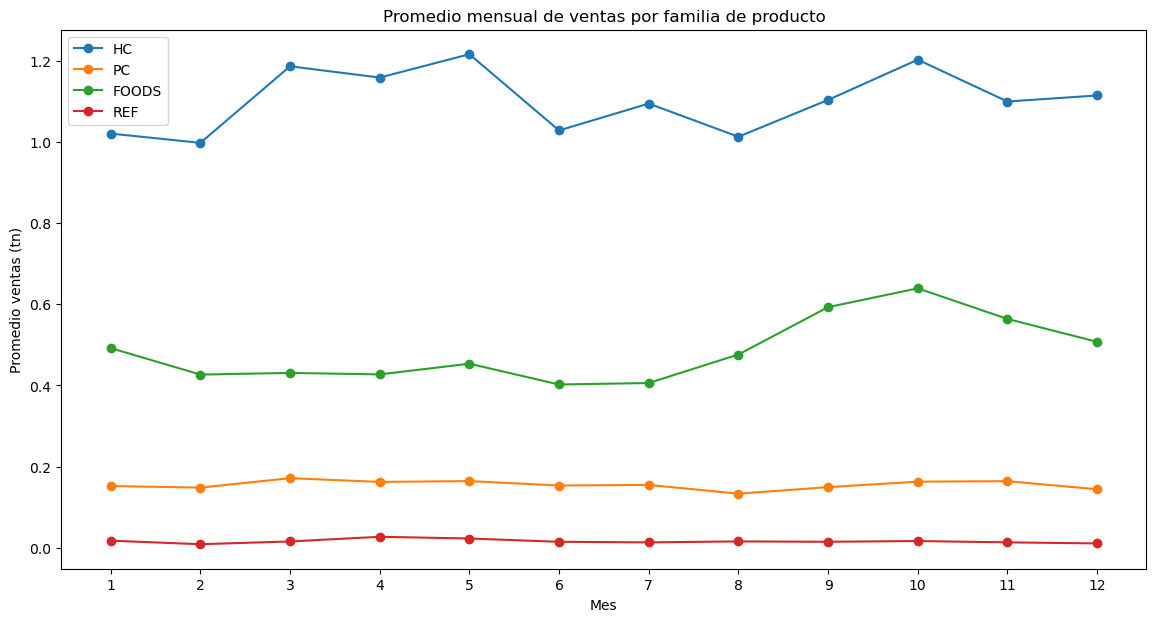

In [36]:
# Agrupar y calcular promedio mensual
promedio_mes_fam = ventas_familia.groupby(['cat1','mes'])['tn'].mean().reset_index()

# Gráfico de líneas, cada familia una curva
plt.figure(figsize=(14,7))
for fam in familias:
    sub = promedio_mes_fam[promedio_mes_fam['cat1'] == fam]
    plt.plot(sub['mes'], sub['tn'], marker='o', label=fam)
plt.legend()
plt.xlabel('Mes')
plt.ylabel('Promedio ventas (tn)')
plt.title('Promedio mensual de ventas por familia de producto')
plt.xticks(range(1,13))
plt.show()

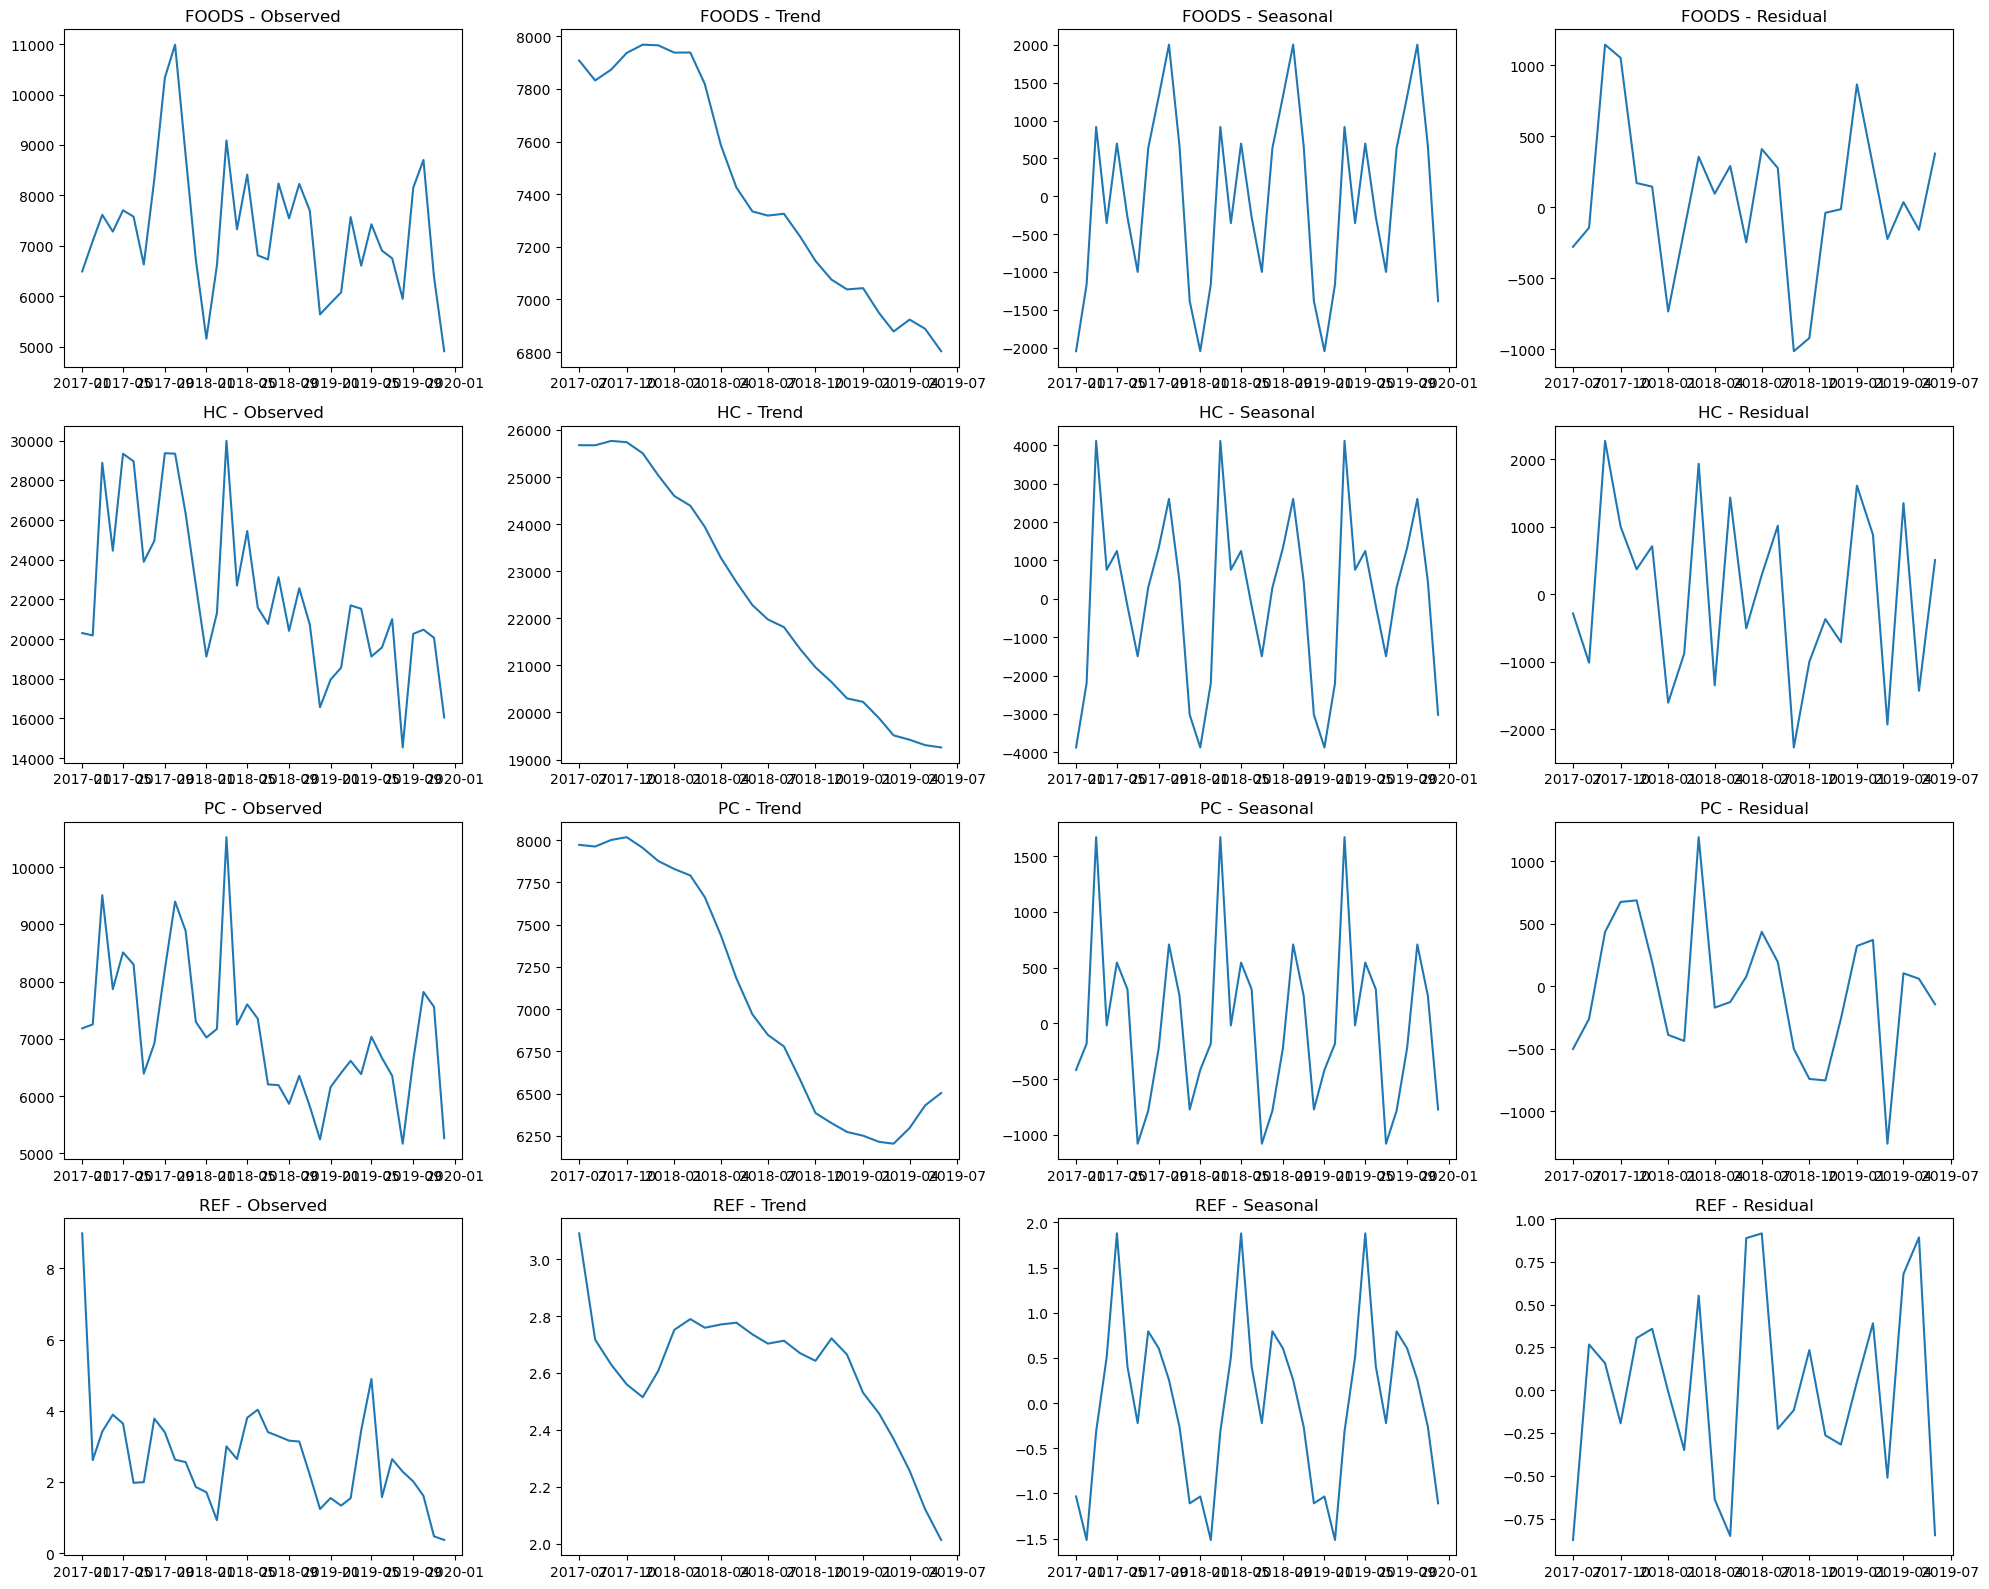

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

familias = ['FOODS', 'HC', 'PC', 'REF']  # o tus familias únicas

fig, axes = plt.subplots(len(familias), 4, figsize=(20, 4*len(familias)))
for i, fam in enumerate(familias):
    serie = ventas_familia[ventas_familia['cat1'] == fam]
    serie = serie.groupby('periodo')['tn'].sum().asfreq('MS')
    decomposition = seasonal_decompose(serie, model='additive', period=12)
    axes[i, 0].plot(decomposition.observed)
    axes[i, 0].set_title(f'{fam} - Observed')
    axes[i, 1].plot(decomposition.trend)
    axes[i, 1].set_title(f'{fam} - Trend')
    axes[i, 2].plot(decomposition.seasonal)
    axes[i, 2].set_title(f'{fam} - Seasonal')
    axes[i, 3].plot(decomposition.resid)
    axes[i, 3].set_title(f'{fam} - Residual')

plt.tight_layout()
plt.show()



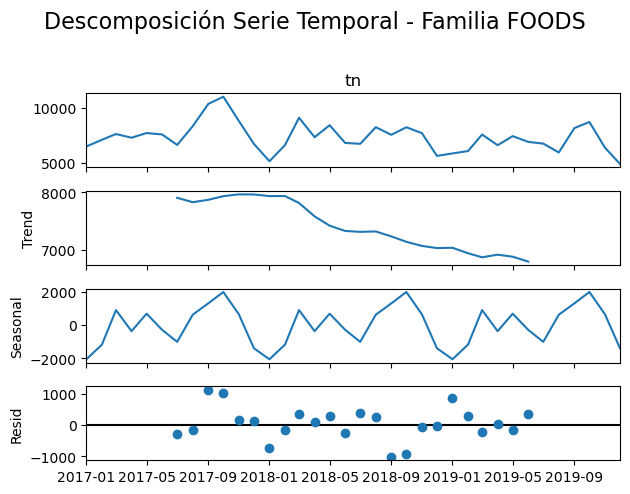

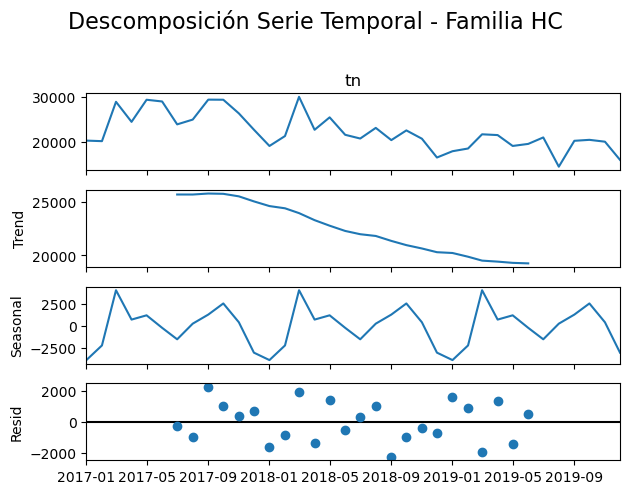

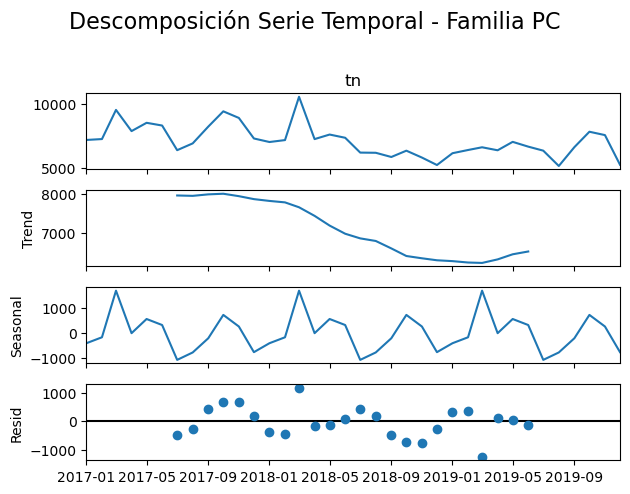

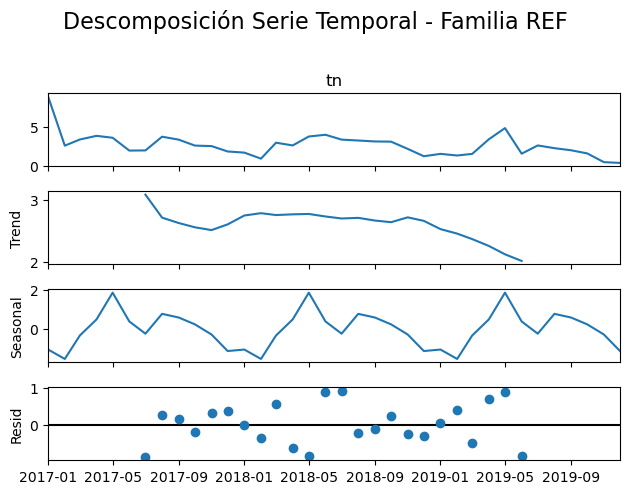

In [40]:
for fam in familias:
    serie = ventas_familia[ventas_familia['cat1'] == fam]
    serie = serie.groupby('periodo')['tn'].sum().asfreq('MS')
    decomposition = seasonal_decompose(serie, model='additive', period=12)
    decomposition.plot()
    plt.suptitle(f'Descomposición Serie Temporal - Familia {fam}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


In [44]:
import pandas as pd

# Unimos sell_in con productos para obtener cat1 y cat2
df = sell_in.merge(productos[['product_id', 'cat1', 'cat2']], on='product_id', how='left')

# Aseguramos que periodo es datetime
#df['periodo'] = pd.to_datetime(df['periodo'].astype(str) + '01', format='%Y%m%d')


In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# def plot_decomposition(df, cat1, cat2, min_periods=24):
#     # Filtrar
#     sub = df[(df['cat1'] == cat1) & (df['cat2'] == cat2)]
#     # Agrupar por periodo mensual
#     serie = sub.groupby('periodo')['tn'].sum()
#     # Reindexar para asegurar frecuencia mensual completa
#     if serie.empty or serie.shape[0] < min_periods:
#         return  # No hay suficiente data para decomponer
#     serie = serie.asfreq('MS')
#     # Descomposición
#     result = seasonal_decompose(serie, model='additive', period=12, extrapolate_trend='freq')
#     # Graficar
#     plt.figure(figsize=(12, 6))
#     plt.plot(result.observed, color='gray', label='Serie original')
#     plt.plot(result.trend, color='blue', linewidth=2, label='Tendencia')
#     plt.plot(result.seasonal, color='green', linestyle='--', linewidth=2, label='Estacionalidad')
#     plt.xlabel("Fecha")
#     plt.ylabel("Toneladas")
#     plt.title(f"{cat1} - {cat2} (descomposición)")
#     plt.legend()
#     plt.grid(axis='x', linestyle=':', color='gray')
#     plt.tight_layout()
#     plt.show()
def plot_decomposition(df, cat1, cat2, min_periods=24):
    # Filtrar
    sub = df[(df['cat1'] == cat1) & (df['cat2'] == cat2)]
    # Agrupar por periodo mensual
    serie = sub.groupby('periodo')['tn'].sum()
    if serie.empty or serie.shape[0] < min_periods:
        return  # No hay suficiente data para decomponer
    serie = serie.asfreq('MS')      # Forzar frecuencia mensual
    serie = serie.fillna(0)         # <-- Solución clave: reemplaza NaN por 0
    # Descomposición
    result = seasonal_decompose(serie, model='additive', period=12, extrapolate_trend='freq')
    # Graficar
    plt.figure(figsize=(12, 6))
    plt.plot(result.observed, color='gray', label='Serie original')
    plt.plot(result.trend, color='blue', linewidth=2, label='Tendencia')
    plt.plot(result.seasonal, color='green', linestyle='--', linewidth=2, label='Estacionalidad')
    plt.xlabel("Fecha")
    plt.ylabel("Toneladas")
    plt.title(f"{cat1} - {cat2} (descomposición)")
    plt.legend()
    plt.grid(axis='x', linestyle=':', color='gray')
    plt.tight_layout()
    plt.show()



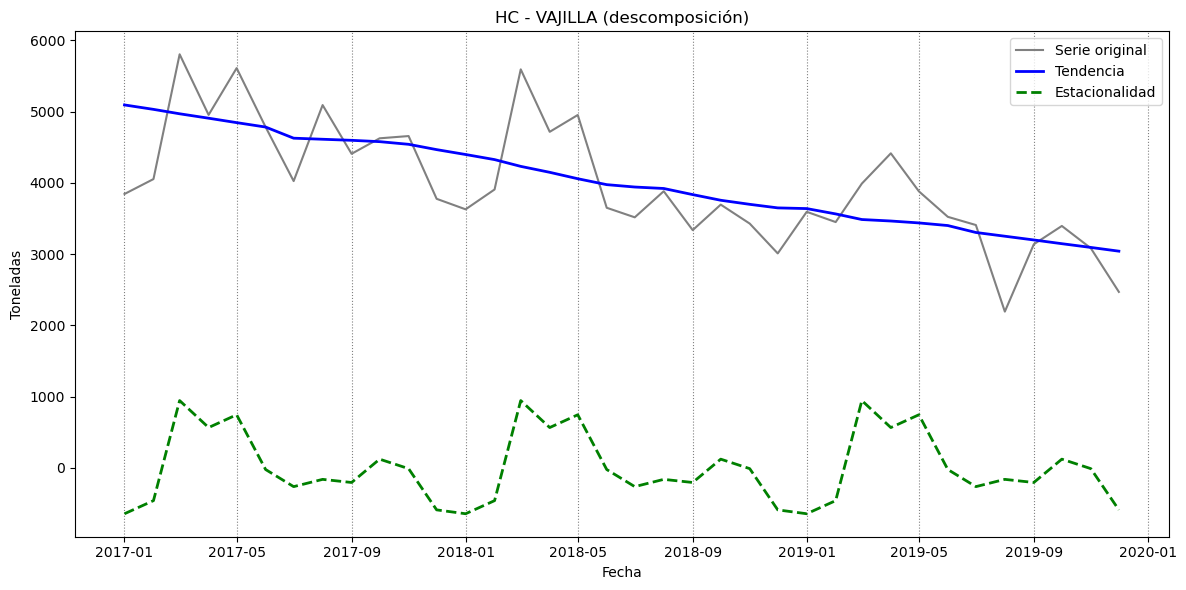

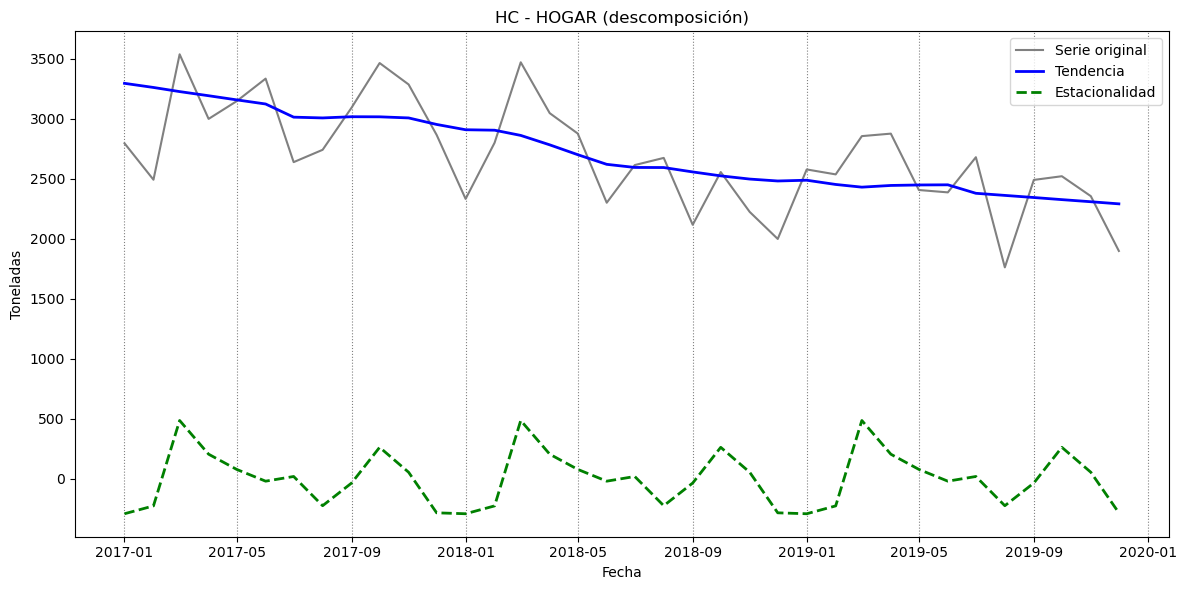

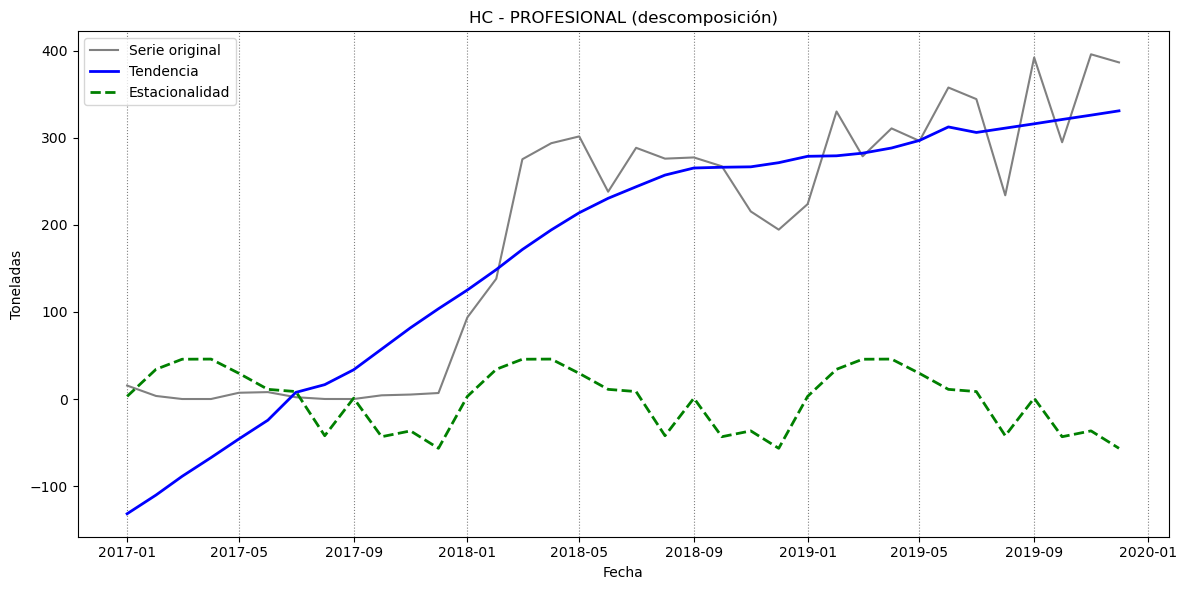

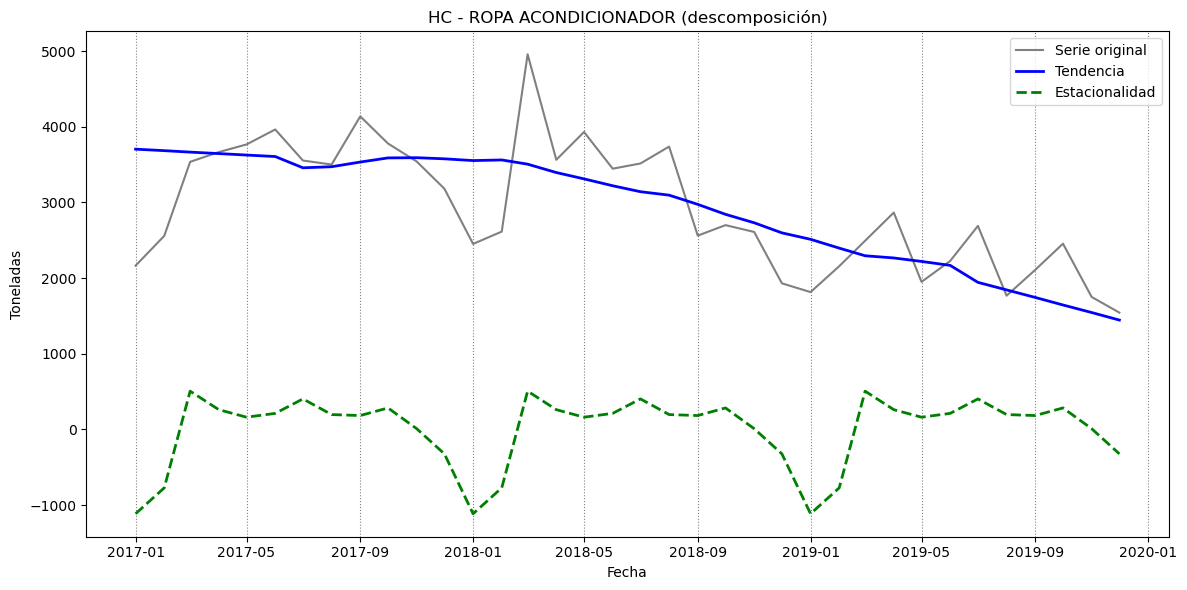

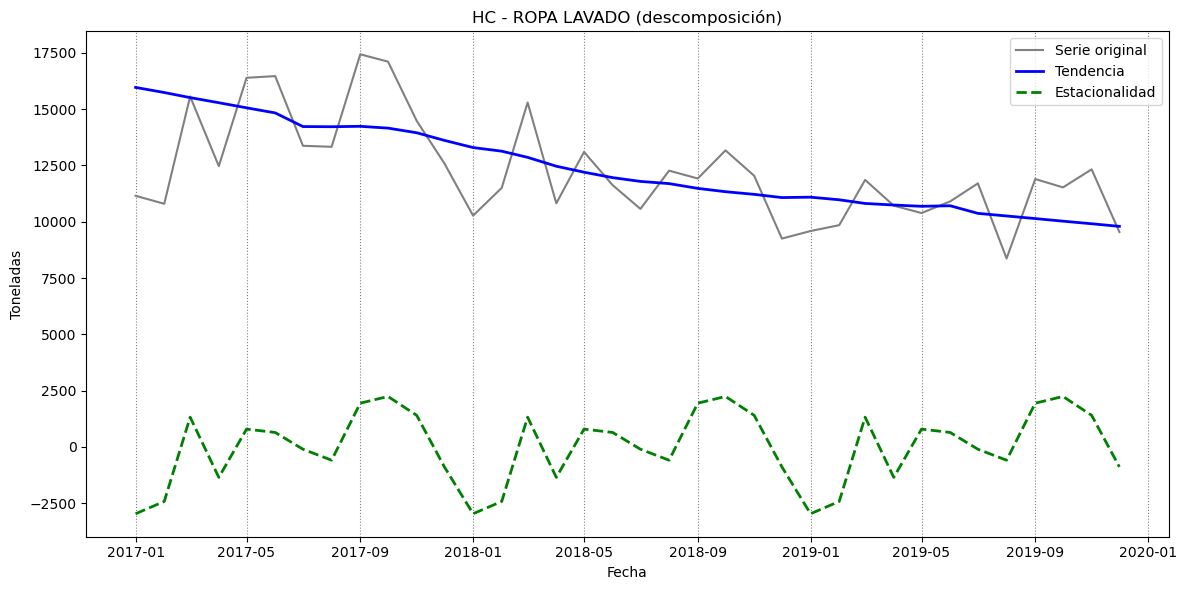

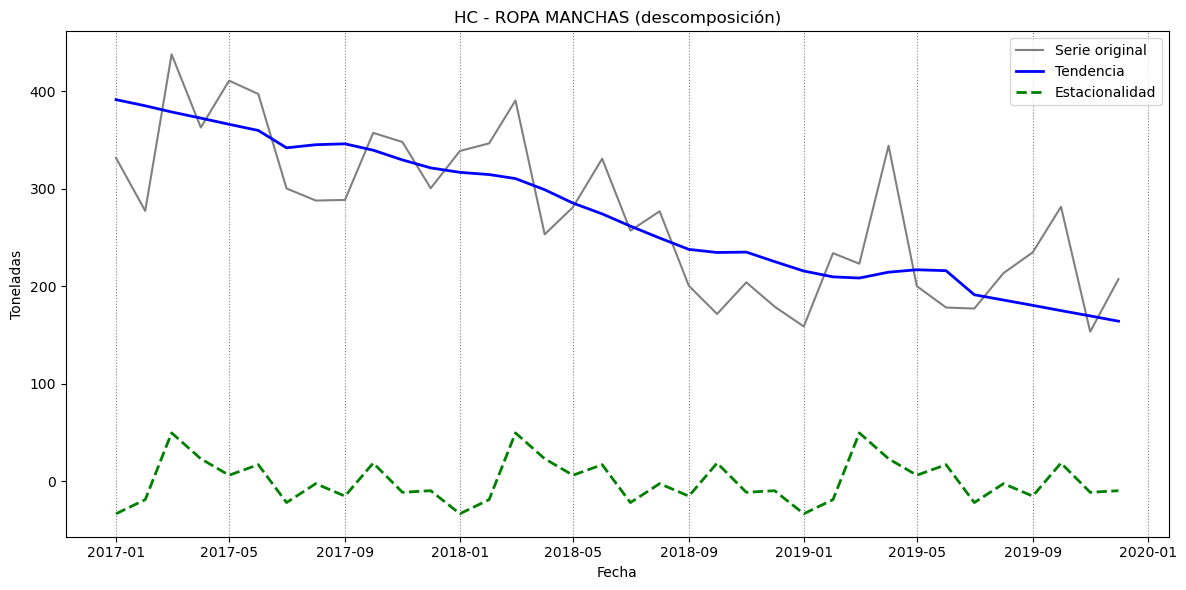

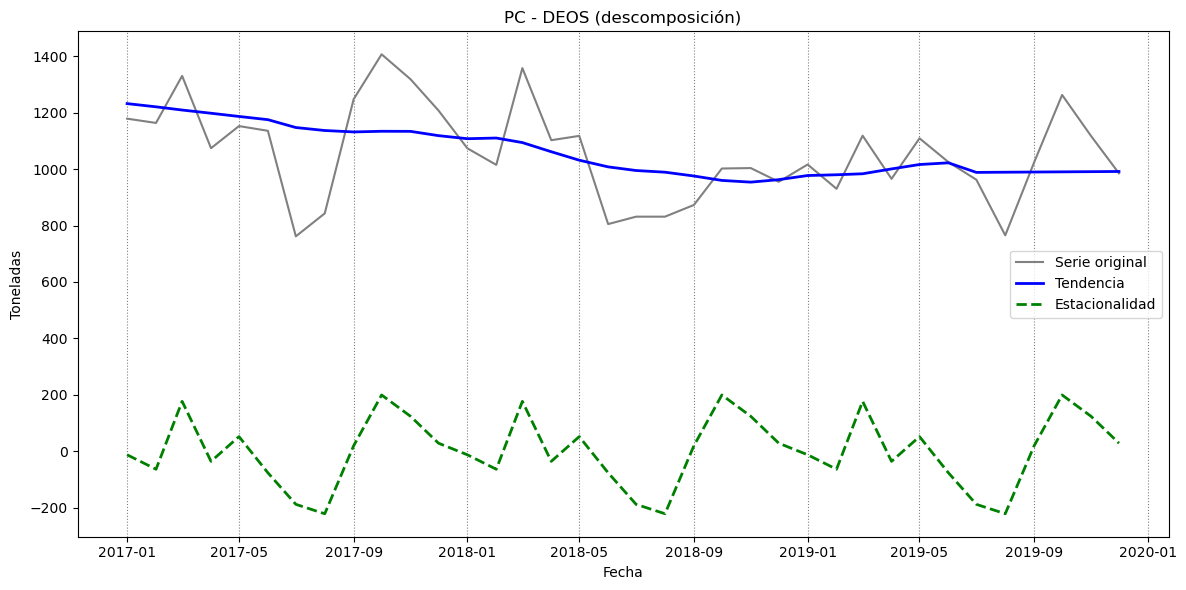

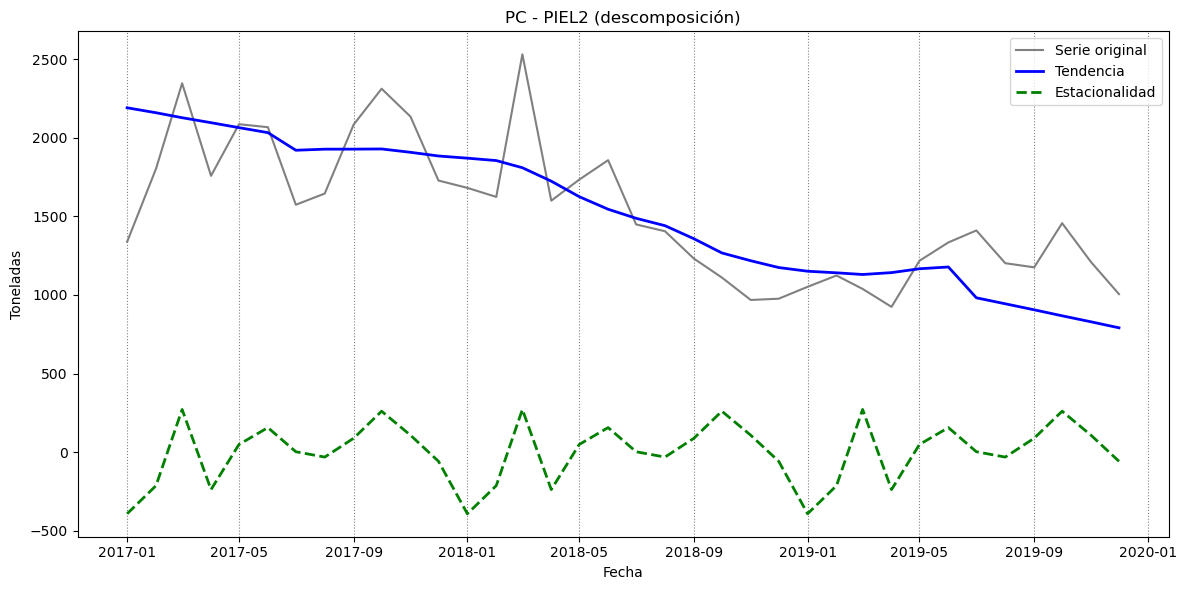

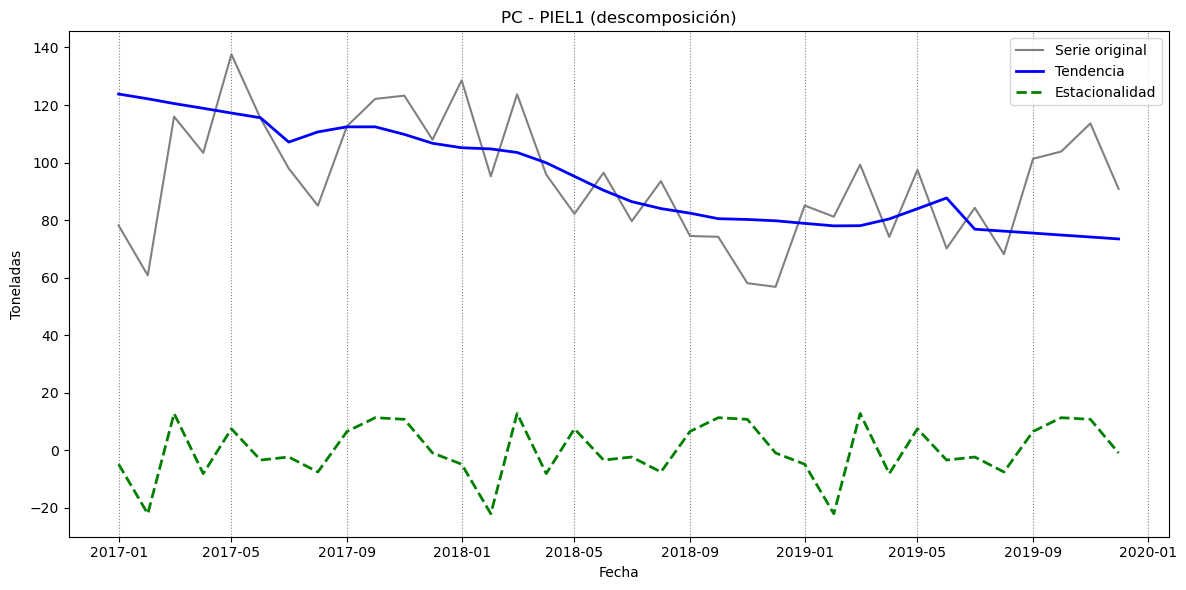

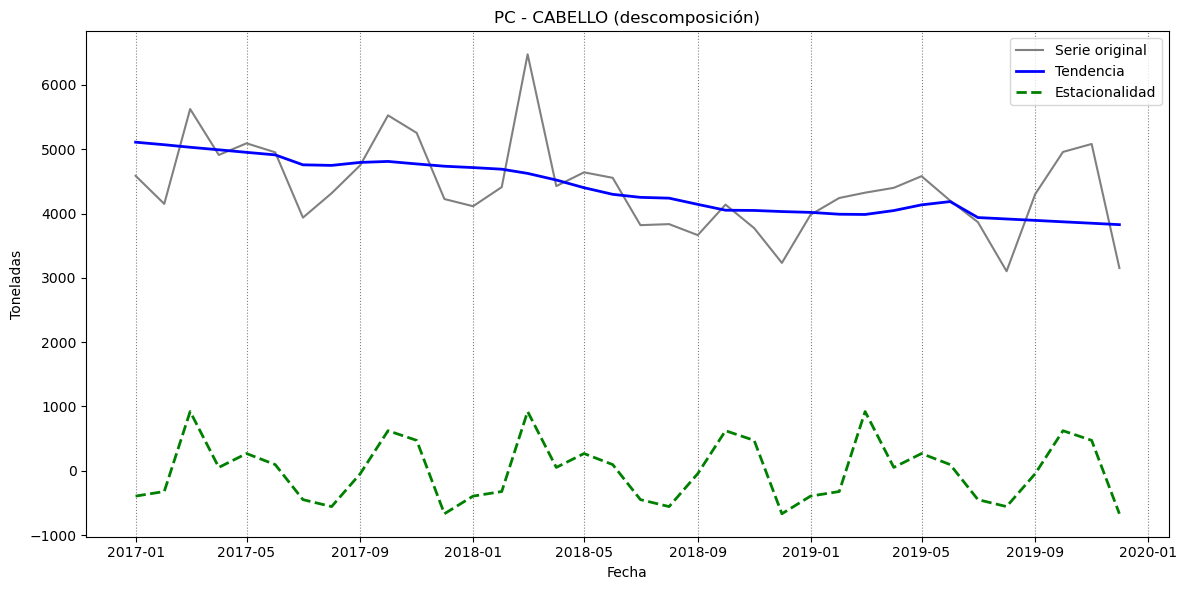

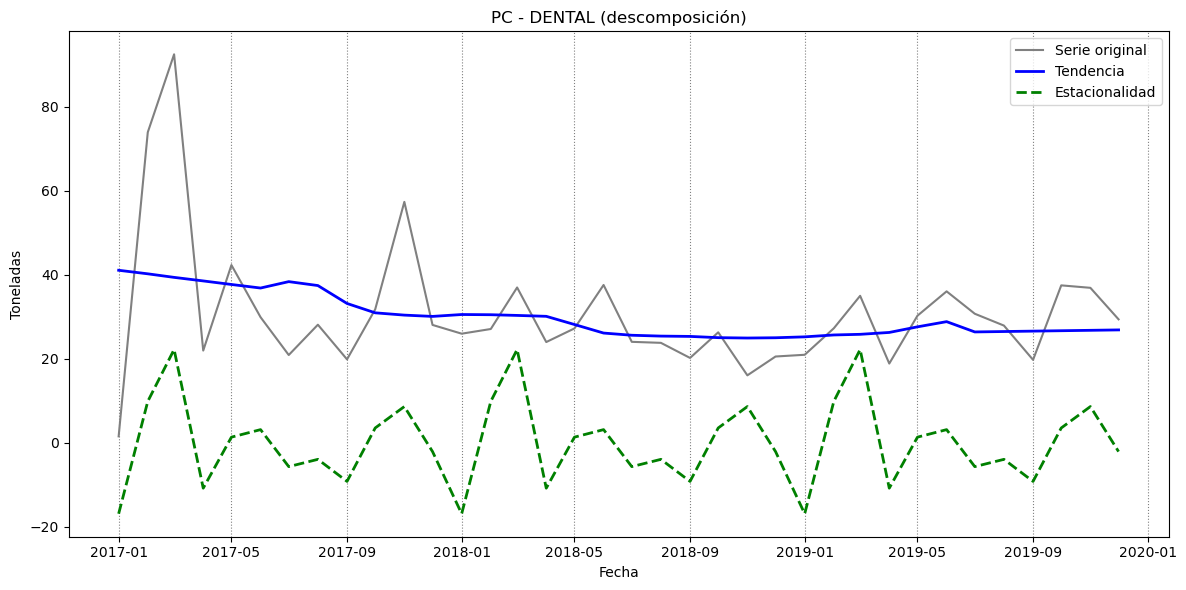

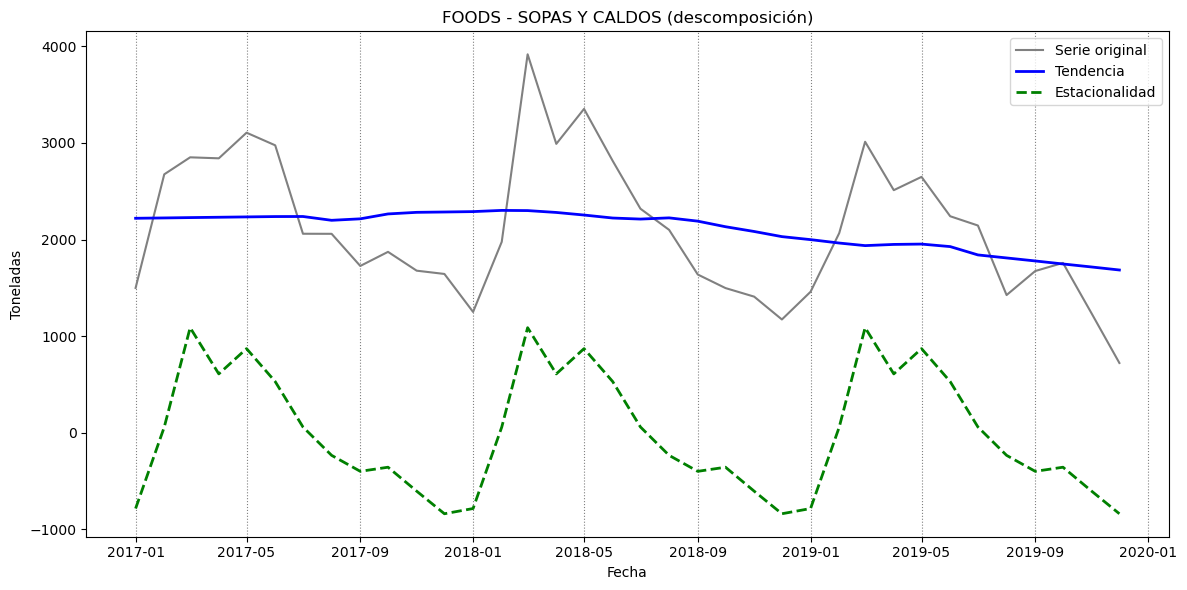

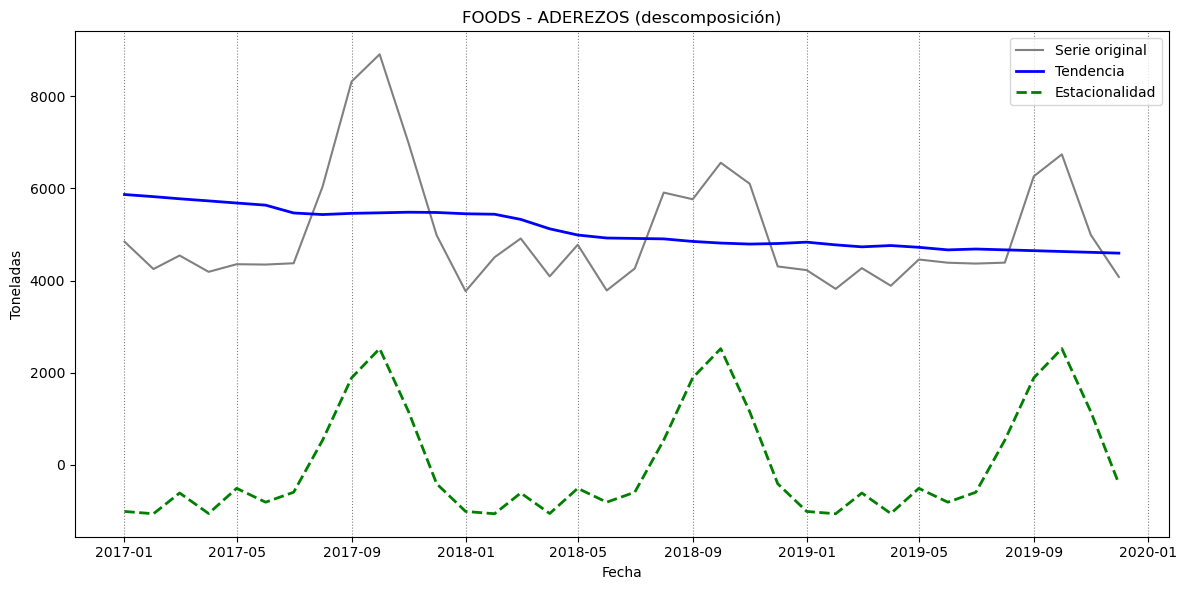

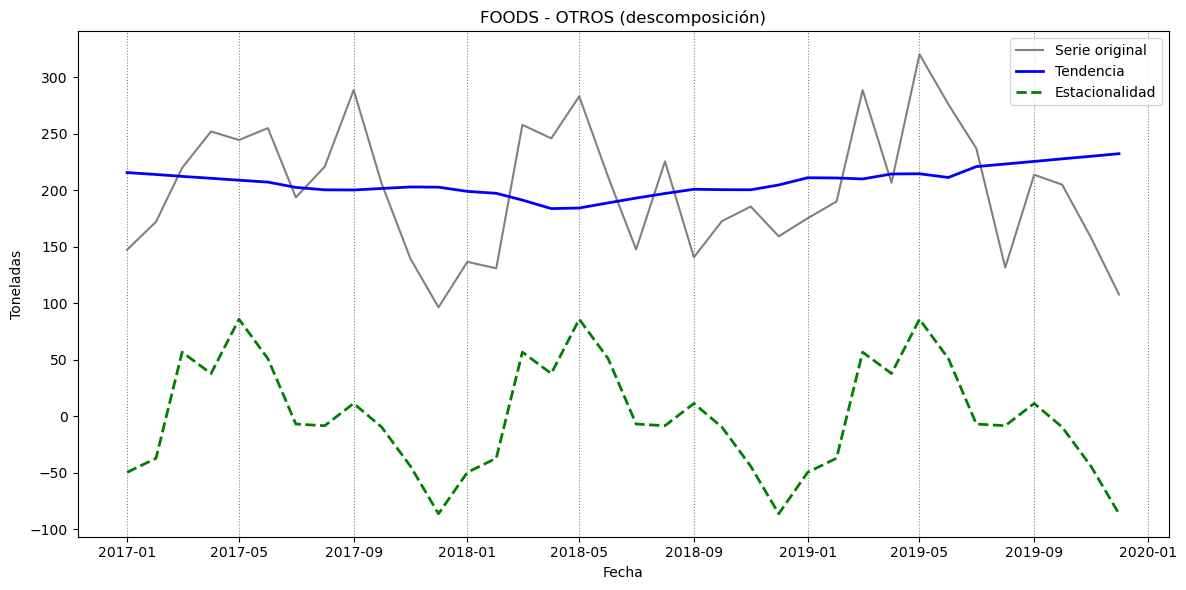

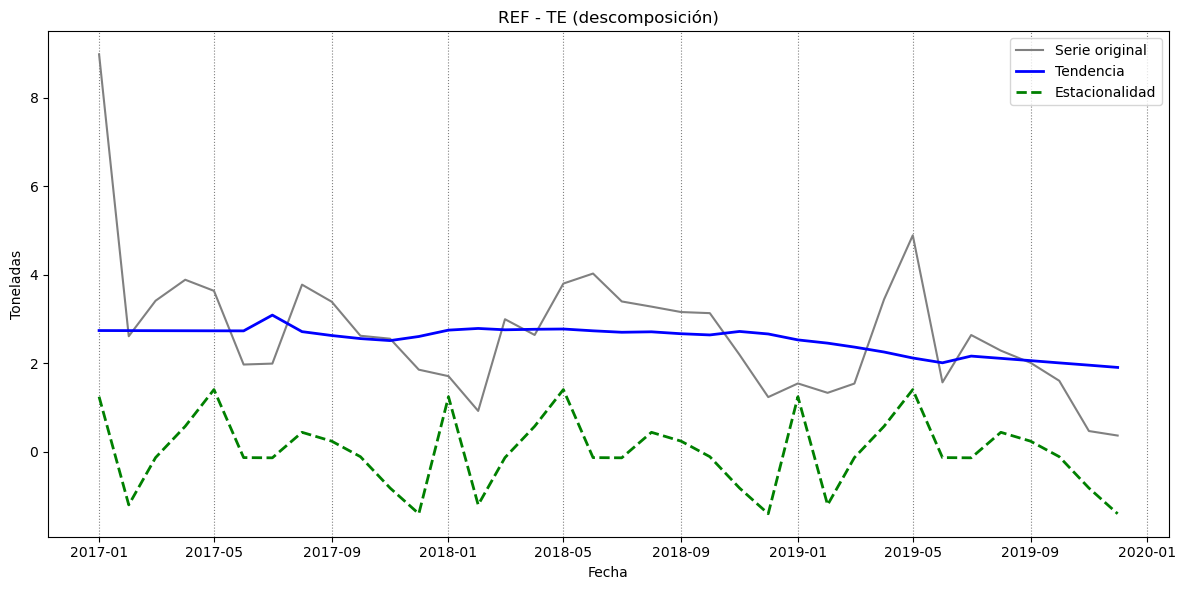

In [ ]:
cat1s = df['cat1'].dropna().unique()

for cat1 in cat1s:
    cat2s = df[df['cat1'] == cat1]['cat2'].dropna().unique()
    for cat2 in cat2s:
        plot_decomposition(df, cat1, cat2,36)
